### Data Understanding

In [1]:
!pip install --upgrade transformers

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from wordcloud import WordCloud
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
import os
os.environ["USE_TF"] = "0"
os.environ["TORCH_COMPILE_DISABLE"] = "1"   # nuke torch.compile globally
os.environ["PYTORCH_TRITON_ENABLE_WARNINGS"] = "0"  # hush warnings

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\steve\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
!pip install tf-keras

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [4]:
from transformers import (
    GenerationConfig,
    TrainingArguments,
    Seq2SeqTrainingArguments,
    Trainer,
    Seq2SeqTrainer,
    EarlyStoppingCallback,
    DataCollatorForSeq2Seq,
    BertModel,
    GPT2LMHeadModel,
    EncoderDecoderModel,
    BertConfig,
    BertTokenizer,
    GPT2Config,
    GPT2Tokenizer,
    BartTokenizer,
    BartForConditionalGeneration,
    T5Tokenizer,
    T5ForConditionalGeneration,
    PegasusTokenizer,
    PegasusForConditionalGeneration
)

c:\Users\steve\anaconda3\envs\learn-env\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
c:\Users\steve\anaconda3\envs\learn-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using Device:", device)
print("CUDA Available:", torch.cuda.is_available())
print("GPU Available:", torch.cuda.is_available())
print("Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")
print("PyTorch Version:", torch.__version__)

# Load model onto GPU
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base").to(device)

Using device: cuda
GPU Available: True
Device Name: NVIDIA GeForce RTX 4070 Ti SUPER
PyTorch Version: 2.5.1
CUDA Available: True


In [ ]:
from datasets import load_dataset

dataset = load_dataset("knkarthick/samsum")
df = dataset["train"].to_pandas()

### EDA

In [27]:
# Show all columns and don't truncate text
pd.set_option('display.max_colwidth', None)

# Now print the first 5 rows fully
print(df.head(5))

         id  \
0  13818513   
1  13728867   
2  13681000   
3  13730747   
4  13728094   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       dialog

In [26]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14732 entries, 0 to 14731
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   14732 non-null  object
 1   dialogue             14732 non-null  object
 2   summary              14732 non-null  object
 3   dialogue_word_count  14732 non-null  int64 
 4   summary_word_count   14732 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 575.6+ KB
None
       dialogue_word_count  summary_word_count
count         14732.000000        14732.000000
mean            124.148656           23.443660
std              94.351600           12.720304
min               0.000000            1.000000
25%              54.000000           14.000000
50%              98.000000           21.000000
75%             169.000000           31.000000
max             995.000000           73.000000


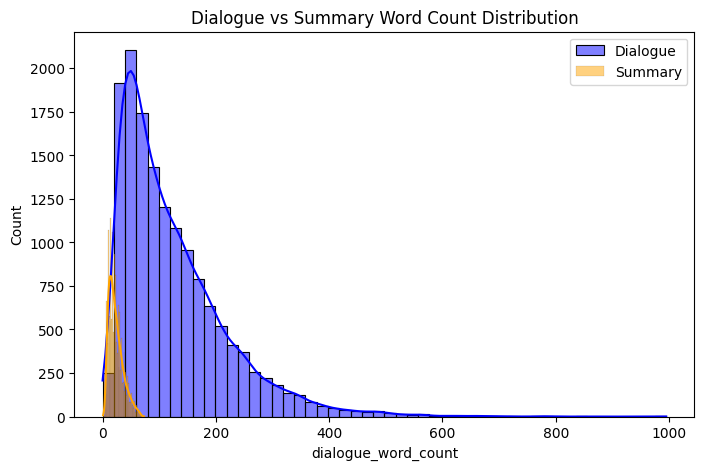

In [19]:
from nltk.tokenize import word_tokenize

# Word counts for dialogue and summary
df['dialogue_word_count'] = df['dialogue'].apply(lambda x: len(word_tokenize(x)))
df['summary_word_count'] = df['summary'].apply(lambda x: len(word_tokenize(x)))

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(df['dialogue_word_count'], bins=50, kde=True, label="Dialogue", color='blue')
sns.histplot(df['summary_word_count'], bins=50, kde=True, label="Summary", color='orange')
plt.legend()
plt.title("Dialogue vs Summary Word Count Distribution")
plt.show()

C:\Users\steve\AppData\Local\Temp\ipykernel_24712\3204262956.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Bigram', data=common_bigrams_df, palette="mako")


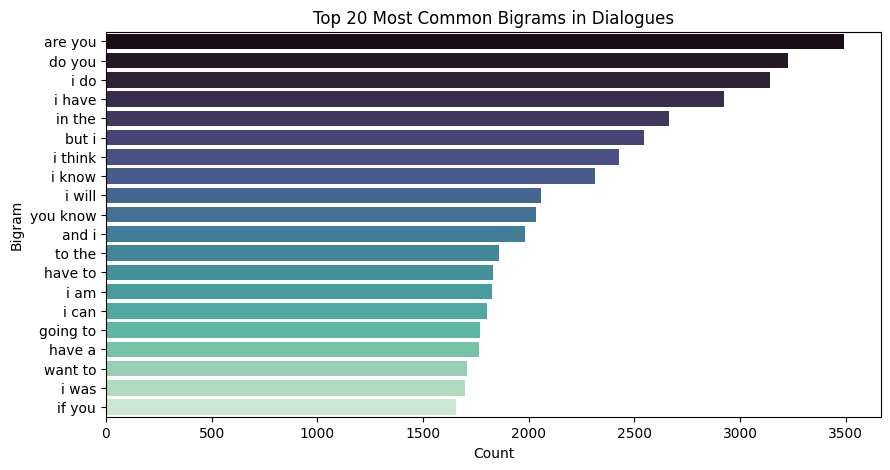

C:\Users\steve\AppData\Local\Temp\ipykernel_24712\3204262956.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Trigram', data=common_trigrams_df, palette="crest")


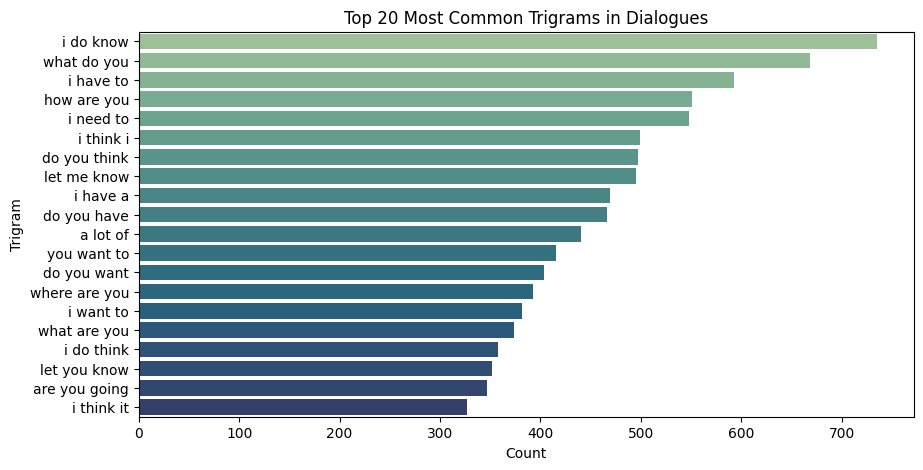

In [21]:
from collections import Counter
from nltk import bigrams, trigrams, word_tokenize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Tokenize and keep only alphabetic words
tokenized_dialogues = [
    [word.lower() for word in word_tokenize(text) if word.isalpha()]
    for text in df['dialogue']
]

# --- Most common bigrams ---
all_bigrams = [bg for tokens in tokenized_dialogues for bg in bigrams(tokens)]
bigram_freq = Counter(all_bigrams)
common_bigrams_df = pd.DataFrame(bigram_freq.most_common(20), columns=['Bigram', 'Count'])
common_bigrams_df['Bigram'] = common_bigrams_df['Bigram'].apply(lambda x: ' '.join(x))

plt.figure(figsize=(10,5))
sns.barplot(x='Count', y='Bigram', data=common_bigrams_df, palette="mako")
plt.title("Top 20 Most Common Bigrams in Dialogues")
plt.show()

# --- Most common trigrams ---
all_trigrams = [tg for tokens in tokenized_dialogues for tg in trigrams(tokens)]
trigram_freq = Counter(all_trigrams)
common_trigrams_df = pd.DataFrame(trigram_freq.most_common(20), columns=['Trigram', 'Count'])
common_trigrams_df['Trigram'] = common_trigrams_df['Trigram'].apply(lambda x: ' '.join(x))

plt.figure(figsize=(10,5))
sns.barplot(x='Count', y='Trigram', data=common_trigrams_df, palette="crest")
plt.title("Top 20 Most Common Trigrams in Dialogues")
plt.show()

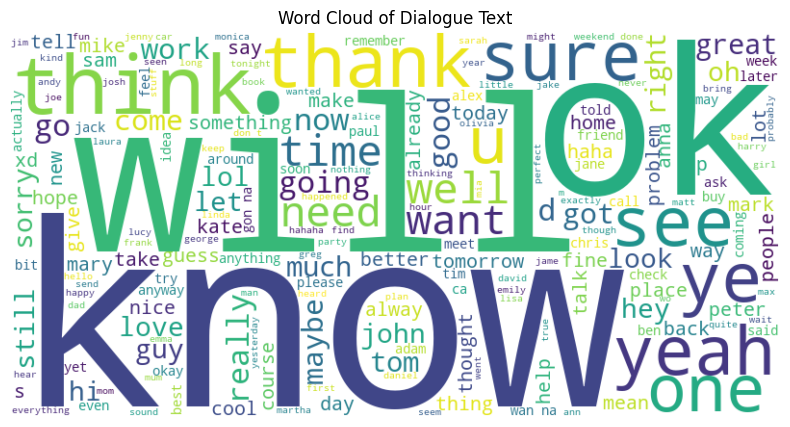

In [22]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Dialogue Text")
plt.show()

### Data Cleaning

In [18]:
import string
import re
import unicodedata
import pandas as pd

def clean_text(text, keep_linebreaks=True):
    # 1) Normalize type + handle missing
    if pd.isna(text):
        return ""
    text = str(text)

    # 2) Unicode normalize (helps with odd punctuation/spacing)
    text = unicodedata.normalize("NFKC", text)

    # 3) Trim weird control chars but keep newlines if desired
    if keep_linebreaks:
        # collapse spaces/tabs but preserve \n
        text = re.sub(r'[ \t]+', ' ', text)
        # reduce excessive blank lines
        text = re.sub(r'\n{3,}', '\n\n', text)
    else:
        # crush all whitespace (including newlines) into single spaces
        text = re.sub(r'\s+', ' ', text)

    # 4) Remove non-printables but allow newline
    text = ''.join(ch for ch in text if ch.isprintable() or ch == '\n')

    # 5) Final trim
    return text.strip()

def clean_example(example):
    example["dialogue"] = clean_text(example["dialogue"], keep_linebreaks=True)
    example["summary"]  = clean_text(example["summary"],  keep_linebreaks=False)
    return example

def is_valid(example):
    return (len(example["dialogue"]) > 10) and (len(example["summary"]) > 5)

df['dialogue'] = df['dialogue'].apply(clean_text)
df['summary'] = df['summary'].apply(clean_text)

# Apply cleaning directly to dataset and overwrite
dataset = dataset.map(clean_example, num_proc=1)  # use num_proc=1 on Windows
dataset = dataset.filter(is_valid, num_proc=1)

Filter: 100%|██████████| 819/819 [00:00<00:00, 51190.45 examples/s]


### Modeling

In [28]:
# Filter out bad entries
def is_valid(example):
    return example["dialogue"] is not None and example["summary"] is not None

dataset = dataset.filter(is_valid)

# Tokenize
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")

def tokenize_function(batch):
    model_inputs = tokenizer(
        batch["dialogue"],
        max_length=512,
        padding="max_length",
        truncation=True,
    )
    labels = tokenizer(
        text_target=batch["summary"],
        max_length=128,
        padding="max_length",
        truncation=True,
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Convert to PyTorch tensors
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

Map: 100%|██████████| 819/819 [00:01<00:00, 724.14 examples/s]


In [39]:
!pip install --upgrade transformers

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [7]:
!pip install rouge_score

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [29]:
from transformers import TrainingArguments, Trainer, BartForConditionalGeneration
import torch, evaluate
from functools import partial

model = BartForConditionalGeneration.from_pretrained("facebook/bart-base").to(device)
collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)
rouge = evaluate.load("rouge")

# We'll generate inside eval by overriding prediction_step via a tiny wrapper.
class GenTrainer(Trainer):
    def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys=None):
        # move batch to device
        inputs = self._prepare_inputs(inputs)
        labels = inputs.get("labels", None)

        # generate summaries
        with torch.no_grad():
            gen_ids = model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs.get("attention_mask"),
                max_length=128,
                num_beams=4,
                no_repeat_ngram_size=3,   # nice anti-repetition tweak
            )

        # IMPORTANT: return TENSORS (not numpy)
        # loss can be None during eval; that's fine
        return (None, gen_ids, labels)

def compute_metrics(eval_pred):
    preds, labels = eval_pred

    # Some HF versions wrap predictions in a tuple
    if isinstance(preds, tuple):
        preds = preds[0]

    # Replace -100 with pad_token_id on BOTH preds and labels
    preds = np.where(preds == -100, tokenizer.pad_token_id, preds)
    labels = np.where(labels == -100, tokenizer.pad_token_id, labels)

    # Decode to strings
    decoded_preds  = tokenizer.batch_decode(preds,   skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels,  skip_special_tokens=True)

    # Normalize whitespace (helps ROUGE be fair)
    decoded_preds  = [" ".join(p.split()) for p in decoded_preds]
    decoded_labels = [" ".join(l.split()) for l in decoded_labels]

    scores = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    return {k: round(v * 100, 2) for k, v in scores.items()}

args = TrainingArguments(
    output_dir="./bart-samsum",
    do_train=True,
    do_eval=True,
    max_steps=2000,  # Set to 1000 for quick testing; adjust as needed
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_steps=200,
    save_total_limit=2,
    torch_compile=False,  # Disable torch.compile for compatibility
)

trainer = GenTrainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()
metrics = trainer.evaluate()
print("\n=== ROUGE SCORES ===")
for k in ['eval_rouge1', 'eval_rouge2', 'eval_rougeL', 'eval_rougeLsum']:
    print(f"{k.replace('eval_', '').upper():<10} : {metrics[k]:.2f}")


C:\Users\steve\AppData\Local\Temp\ipykernel_24712\3009543372.py:67: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `GenTrainer.__init__`. Use `processing_class` instead.
  trainer = GenTrainer(


Step,Training Loss
200,1.709700
400,0.435200
600,0.404600
800,0.395200
1000,0.393500
1200,0.387700
1400,0.384800
1600,0.372000
1800,0.371100
2000,0.339800


c:\Users\steve\anaconda3\envs\learn-env\lib\site-packages\transformers\modeling_utils.py:3909: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(



=== ROUGE SCORES ===
ROUGE1     : 50.54
ROUGE2     : 26.37
ROUGEL     : 42.23
ROUGELSUM  : 42.22


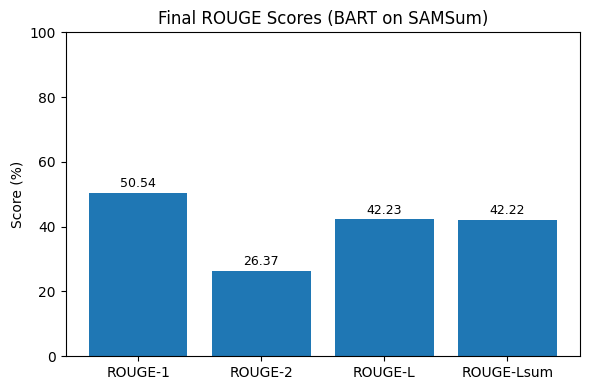

In [30]:
import matplotlib.pyplot as plt

def plot_final_rouge(metrics):
    keys = ["eval_rouge1", "eval_rouge2", "eval_rougeL", "eval_rougeLsum"]
    labels = ["ROUGE-1", "ROUGE-2", "ROUGE-L", "ROUGE-Lsum"]
    vals = [float(metrics[k]) for k in keys if k in metrics]
    labs = [labels[i] for i, k in enumerate(keys) if k in metrics]

    plt.figure(figsize=(6,4))
    bars = plt.bar(labs, vals)
    for b, v in zip(bars, vals):
        plt.text(b.get_x()+b.get_width()/2, v+0.8, f"{v:.2f}", ha="center", va="bottom", fontsize=9)
    plt.title("Final ROUGE Scores (BART on SAMSum)")
    plt.ylabel("Score (%)")
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

# Call these:
plot_final_rouge(metrics)


In [31]:
def batch_summarize(dialogues):
    inputs = tokenizer(
        dialogues,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=512
    ).to(device)

    with torch.no_grad():
        outs = model.generate(
            **inputs,
            max_new_tokens=64,
            num_beams=4,
            no_repeat_ngram_size=3
        )

    return tokenizer.batch_decode(outs, skip_special_tokens=True)


# grab the first 5 validation samples
samples = [dataset["validation"][j]["dialogue"] for j in range(5)]
gold_summaries = [dataset["validation"][j]["summary"] for j in range(5)]
preds = batch_summarize(samples)

for j, (dialogue, gold, pred) in enumerate(zip(samples, gold_summaries, preds)):
    print(f"\n=== SAMPLE {j} ===")
    print(f"--- ORIGINAL DIALOGUE ---\n{dialogue[:500]}{'...' if len(dialogue) > 500 else ''}")
    print(f"\n--- ORIGINAL SUMMARY ---\n{gold}")
    print(f"\n--- MODEL PREDICTION ---\n{pred}")



=== SAMPLE 0 ===
--- ORIGINAL DIALOGUE ---
A: Hi Tom, are you busy tomorrow’s afternoon?
B: I’m pretty sure I am. What’s up?
A: Can you go with me to the animal shelter?.
B: What do you want to do?
A: I want to get a puppy for my son.
B: That will make him so happy.
A: Yeah, we’ve discussed it many times. I think he’s ready now.
B: That’s good. Raising a dog is a tough issue. Like having a baby ;-) 
A: I'll get him one of those little dogs.
B: One that won't grow up too big;-)
A: And eat too much;-))
B: Do you know which one he would lik...

--- ORIGINAL SUMMARY ---
A will go to the animal shelter tomorrow to get a puppy for her son. They already visited the shelter last Monday and the son chose the puppy.

--- MODEL PREDICTION ---
A wants to get a puppy for her son. She took him to the animal shelter last Monday.

=== SAMPLE 1 ===
--- ORIGINAL DIALOGUE ---
Emma: I’ve just fallen in love with this advent calendar! Awesome! I wanna one for my kids!
Rob: I used to get one every year as 

In [32]:
# 1) Put model in eval mode
import re, torch

def _post_edit(summary: str) -> str:
    # Turn "pizza and X" into "pizza with X"
    summary = re.sub(r'(?i)\bpizza and ([a-z0-9 ,\-]+)', r'pizza with \1', summary)
    # Tiny cleanups
    summary = re.sub(r'\s+', ' ', summary).strip()
    return summary

def summarize_order(dialogue: str) -> str:
    prompt = (
        "Task: Write one sentence summarizing the final pizza order.\n"
        "Rules: Use 'pizza with <toppings>'; include who placed the order; ignore side chatter.\n\n"
        f"Chat:\n{dialogue}\n\nSummary:"
    )
    inputs = tokenizer([prompt], return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    model.eval()
    with torch.no_grad():
        gen_ids = model.generate(
            **inputs,
            max_new_tokens=48,
            num_beams=6,            # a bit more careful than 4
            length_penalty=0.9,     # encourage concise but not too short
            no_repeat_ngram_size=3
        )
    text = tokenizer.decode(gen_ids[0], skip_special_tokens=True).strip()
    return _post_edit(text)

chat = """Alex: I’m starving
Jamie: same, what should we get?
Alex: pizza?
Jamie: yes, but no pineapple this time
Alex: rude, pineapple is elite
Jamie: I’m not debating this again
Alex: fine, half pineapple, half pepperoni?
Jamie: deal. Extra cheese too.
Alex: already placing the order
Jamie: you’re my hero"""

print(summarize_order(chat))

Task asks Alex to write a sentence summarizing the final pizza order.


### BERT seq2seq 

In [56]:
from transformers import (
    EncoderDecoderModel, AutoTokenizer, AutoConfig,
    DataCollatorForSeq2Seq, TrainingArguments, Trainer
)
import torch, numpy as np, evaluate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cuda.matmul.allow_tf32 = True
torch.set_float32_matmul_precision("high")

bert_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(bert_name)

added_pad = False
# ensure PAD exists (if you added it earlier, keep it; else add & resize both enc/dec)
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({"pad_token": "[PAD]"})
    model.encoder.resize_token_embeddings(len(tokenizer))
    model.decoder.resize_token_embeddings(len(tokenizer))

ids = dict(
    decoder_start_token_id=tokenizer.cls_token_id,
    bos_token_id=tokenizer.cls_token_id,
    eos_token_id=tokenizer.sep_token_id,
    pad_token_id=tokenizer.pad_token_id,
)

# set on the wrapper config AND the decoder's own config (older versions can be picky)
for k, v in ids.items():
    setattr(model.config, k, v)
    setattr(model.decoder.config, k, v)

# if GenerationConfig exists, sync it too so generate() picks it up
try:
    from transformers import GenerationConfig
    gen = getattr(model, "generation_config", None)
    model.generation_config = GenerationConfig(**({**(gen.to_dict() if gen else {}), **ids}))
except Exception:
    pass

# sanity check
print("decoder_start_token_id:", model.config.decoder_start_token_id,
      "| bos:", model.config.bos_token_id,
      "| eos:", model.config.eos_token_id,
      "| pad:", model.config.pad_token_id)

enc_cfg = AutoConfig.from_pretrained(bert_name)
dec_cfg = AutoConfig.from_pretrained(bert_name)
dec_cfg.is_decoder = True
dec_cfg.add_cross_attention = True

model = EncoderDecoderModel.from_encoder_decoder_pretrained(
    bert_name, bert_name, encoder_config=enc_cfg, decoder_config=dec_cfg
).to(device)

if added_pad:
    new_vocab_size = len(tokenizer)
    model.encoder.resize_token_embeddings(new_vocab_size)
    model.decoder.resize_token_embeddings(new_vocab_size)
    model.config.vocab_size = new_vocab_size  # optional but tidy

# Special tokens / generation defaults
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.bos_token_id           = tokenizer.cls_token_id
model.config.eos_token_id           = tokenizer.sep_token_id
model.config.pad_token_id           = tokenizer.pad_token_id

model.config.no_repeat_ngram_size = 3
model.config.length_penalty       = 1.1
model.config.num_beams            = 4
model.config.max_new_tokens       = 128
model.config.min_new_tokens       = 20
model.config.use_cache = False



decoder_start_token_id: 101 | bos: 101 | eos: 102 | pad: 0


Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.bias', 'bert.e

In [57]:
from datasets import DatasetDict

MAX_SRC, MAX_TGT = 512, 128

def preprocess(batch):
    enc = tokenizer(
        batch["dialogue"],
        max_length=MAX_SRC,
        truncation=True,
        padding=False,
    )
    with tokenizer.as_target_tokenizer():
        dec = tokenizer(
            batch["summary"],
            max_length=MAX_TGT,
            truncation=True,
            padding=False,
        )
    enc["labels"] = dec["input_ids"]
    return enc

# IMPORTANT: build this with the same HF dataset splits you cleaned
tokenized_dataset = dataset.map(
    preprocess,
    batched=True,
    remove_columns=dataset["train"].column_names
)


Map:   0%|          | 0/14729 [00:00<?, ? examples/s]c:\Users\steve\anaconda3\envs\learn-env\lib\site-packages\transformers\tokenization_utils_base.py:4006: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Map: 100%|██████████| 819/819 [00:00<00:00, 7378.39 examples/s]


In [58]:
from transformers import DataCollatorForSeq2Seq
import evaluate

collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    pad_to_multiple_of=8   # tensor-core friendly
)

rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    if isinstance(preds, tuple):
        preds = preds[0]
    # Replace -100 with pad_token_id
    preds  = np.where(preds  == -100, tokenizer.pad_token_id, preds)
    labels = np.where(labels == -100, tokenizer.pad_token_id, labels)

    decoded_preds  = [" ".join(s.split()) for s in tokenizer.batch_decode(preds,  skip_special_tokens=True)]
    decoded_labels = [" ".join(s.split()) for s in tokenizer.batch_decode(labels, skip_special_tokens=True)]

    scores = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    return {k: round(v * 100, 2) for k, v in scores.items()}


s = tokenized_dataset["train"][0]
print(tokenizer.decode(s["input_ids"][:100]))
print(tokenizer.decode([t for t in s["labels"][:100] if t != -100]))


[CLS] amanda : i baked cookies. do you want some? jerry : sure! amanda : i ' ll bring you tomorrow : - ) [SEP]
[CLS] amanda baked cookies and will bring jerry some tomorrow. [SEP]


In [62]:
from transformers import TrainingArguments, Trainer, TrainerCallback
import torch, numpy as np

# lean args: remove predict_with_generate & generation_* (we generate in GenTrainer)
args = TrainingArguments(
    output_dir="./bert2bert-samsum-test",
    do_train=True,
    do_eval=True,
    max_steps=2000,                # quick test budget
    learning_rate=3e-5,
    warmup_ratio=0.06,
    lr_scheduler_type="cosine",
    # label_smoothing_factor might be unavailable on very old versions.
    # If you get an error, comment the next line out.
    label_smoothing_factor=0.1,

    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=1,

    logging_steps=200,
    save_total_limit=1,

    # keep optimizer generic for wider version support
    optim="adamw_torch",

    # safer across versions than bf16
    fp16=(torch.cuda.is_available() and torch.cuda.get_device_capability()[0] < 8),
    # if your version supports bf16 and you want it:
    # bf16=(torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8),

    gradient_checkpointing=True,
    dataloader_num_workers=2,      # on Windows, small is safer
    dataloader_pin_memory=True,
    torch_compile=False,
)

# eval every N steps via callback (no evaluation_strategy needed)
class EvalEveryNSteps(TrainerCallback):
    def __init__(self, steps=800): self.steps = steps
    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step and state.global_step % self.steps == 0:
            control.should_evaluate = True
        return control

# generate during eval even on older versions
class GenTrainer(Trainer):
    def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys=None):
        inputs = self._prepare_inputs(inputs)
        labels = inputs.get("labels", None)
        with torch.no_grad():
            gen_ids = model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs.get("attention_mask"),
                max_new_tokens=64,
                min_new_tokens=10,
                num_beams=2,
                no_repeat_ngram_size=3,
                decoder_start_token_id=model.config.decoder_start_token_id,
                eos_token_id=model.config.eos_token_id,
                pad_token_id=model.config.pad_token_id,
            )
        return (None, gen_ids, labels)

trainer = GenTrainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EvalEveryNSteps(800)],
)

trainer.train()
metrics = trainer.evaluate()
print("\n=== BERT2BERT ROUGE")
for k in ['eval_rouge1','eval_rouge2','eval_rougeL','eval_rougeLsum']:
    print(f"{k.replace('eval_','').upper():<10}: {metrics.get(k, float('nan')):.2f}")



C:\Users\steve\AppData\Local\Temp\ipykernel_24712\3478840877.py:65: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `GenTrainer.__init__`. Use `processing_class` instead.
  trainer = GenTrainer(



=== BERT2BERT ROUGE
ROUGE1    : 13.56
ROUGE2    : 1.60
ROUGEL    : 12.09
ROUGELSUM : 12.08


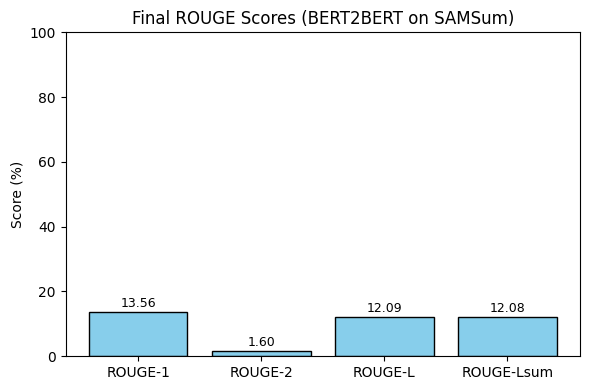

In [63]:
import matplotlib.pyplot as plt

def plot_final_rouge(metrics):
    keys = ["eval_rouge1", "eval_rouge2", "eval_rougeL", "eval_rougeLsum"]
    labels = ["ROUGE-1", "ROUGE-2", "ROUGE-L", "ROUGE-Lsum"]
    vals = [float(metrics[k]) for k in keys if k in metrics]
    labs = [labels[i] for i, k in enumerate(keys) if k in metrics]

    plt.figure(figsize=(6,4))
    bars = plt.bar(labs, vals, color="skyblue", edgecolor="black")
    for b, v in zip(bars, vals):
        plt.text(
            b.get_x() + b.get_width()/2,
            v + 0.8,
            f"{v:.2f}",
            ha="center",
            va="bottom",
            fontsize=9
        )
    plt.title("Final ROUGE Scores (BERT2BERT on SAMSum)")
    plt.ylabel("Score (%)")
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

# Call after evaluation:
plot_final_rouge(metrics)


In [64]:
def test_dialogues(dialogues, refs=None, max_new=96, beams=4):
    # Tokenize on the right device
    enc = tokenizer(
        dialogues, return_tensors="pt", truncation=True, padding=True, max_length=512
    )
    enc = {k: v.to(model.device) for k, v in enc.items()}

    with torch.no_grad():
        gen = model.generate(
            **enc,
            max_new_tokens=max_new,
            min_new_tokens=20,           # keeps outputs from being too short
            num_beams=beams,
            no_repeat_ngram_size=3,
            length_penalty=1.1,
            decoder_start_token_id=model.config.decoder_start_token_id,
            eos_token_id=model.config.eos_token_id,
            pad_token_id=model.config.pad_token_id,
        )

    preds = tokenizer.batch_decode(gen, skip_special_tokens=True)

    for i, d in enumerate(dialogues):
        print(f"\n=== SAMPLE {i} ===")
        print(f"--- DIALOGUE ---\n{d[:600]}{'...' if len(d) > 600 else ''}")
        if refs is not None and i < len(refs):
            print(f"\n--- REFERENCE ---\n{refs[i]}")
        print(f"\n--- PREDICTION ---\n{preds[i]}")
    return preds

val_idx = [0, 1, 2, 3, 4]
samples = [dataset["validation"][i]["dialogue"] for i in val_idx]
refs    = [dataset["validation"][i]["summary"] for i in val_idx]
_ = test_dialogues(samples, refs=refs, beams=4)


=== SAMPLE 0 ===
--- DIALOGUE ---
A: Hi Tom, are you busy tomorrow’s afternoon?
B: I’m pretty sure I am. What’s up?
A: Can you go with me to the animal shelter?.
B: What do you want to do?
A: I want to get a puppy for my son.
B: That will make him so happy.
A: Yeah, we’ve discussed it many times. I think he’s ready now.
B: That’s good. Raising a dog is a tough issue. Like having a baby ;-) 
A: I'll get him one of those little dogs.
B: One that won't grow up too big;-)
A: And eat too much;-))
B: Do you know which one he would like?
A: Oh, yes, I took him there last Monday. He showed me one that he really liked.
B: I bet you had...

--- REFERENCE ---
A will go to the animal shelter tomorrow to get a puppy for her son. They already visited the shelter last Monday and the son chose the puppy.

--- PREDICTION ---
tom is going to s the the the a the the her. she will s a the a a the. she is to s her. they ' s to s to t be to the. he ' s her to s a her. he and she ' t to t to go ' t be a the

### T5

In [75]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_id = "google/flan-t5-base"   # start with base for a quick smoke test
# model_id = "google/flan-t5-large"  # switch to large once it works

tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
model = AutoModelForSeq2SeqLM.from_pretrained(model_id).to(device)
model.config.use_cache = False

In [76]:
# 1) Re-tokenize SAMSum with the T5 tokenizer (CRITICAL)
MAX_SRC, MAX_TGT = 512, 128

def preprocess_t5(batch):
    inputs = ["summarize: " + d for d in batch["dialogue"]]
    enc = tokenizer(inputs, max_length=MAX_SRC, truncation=True, padding=False)
    try:
        with tokenizer.as_target_tokenizer():
            dec = tokenizer(batch["summary"], max_length=MAX_TGT, truncation=True, padding=False)
    except AttributeError:  # older transformers
        dec = tokenizer(text_target=batch["summary"], max_length=MAX_TGT, truncation=True, padding=False)
    enc["labels"] = dec["input_ids"]
    return enc

tokenized_t5 = dataset.map(
    preprocess_t5,
    batched=True,
    remove_columns=dataset["train"].column_names
)

# 2) Small fast subsets (freshly built with T5 tokens)
small_train = tokenized_t5["train"].shuffle(seed=42).select(range(2000))
small_val   = tokenized_t5["validation"].shuffle(seed=42).select(range(400))

# 3) Collator for seq2seq (uses T5 tokenizer to pad + set labels=-100 on PAD)
from transformers import DataCollatorForSeq2Seq
collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, pad_to_multiple_of=8)

# 4) Sanity check one example BEFORE training
ex = small_train[0]
print("INPUT  :", tokenizer.decode(ex["input_ids"][:150]))
print("LABELS :", tokenizer.decode([t for t in ex["labels"] if t != -100][:120]))


Map:   0%|          | 0/14729 [00:00<?, ? examples/s]c:\Users\steve\anaconda3\envs\learn-env\lib\site-packages\transformers\tokenization_utils_base.py:4006: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Map: 100%|██████████| 819/819 [00:00<00:00, 7875.14 examples/s]

INPUT  : summarize: Chris: can I borrow your car? Finn: what for? Chris: I have a date Finn: with who? Chris: Crystal Finn: wow, bro, she's hot <unk> Chris: so, what about the car? Finn: sure, but you need to fuel Chris: thanks, bro</s>
LABELS : Finn is going to lend his car to Chris, who needs it for a date with Crystal. Chris will refuel the car.</s>


In [77]:
from transformers import DataCollatorForSeq2Seq

collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer, model=model, pad_to_multiple_of=8
)

In [78]:
import numpy as np, evaluate
rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    if isinstance(preds, tuple): preds = preds[0]
    preds  = np.where(preds  == -100, tokenizer.pad_token_id, preds)
    labels = np.where(labels == -100, tokenizer.pad_token_id, labels)

    decoded_preds  = [" ".join(s.split()) for s in tokenizer.batch_decode(preds,  skip_special_tokens=True)]
    decoded_labels = [" ".join(s.split()) for s in tokenizer.batch_decode(labels, skip_special_tokens=True)]
    scores = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    return {k: round(v*100, 2) for k, v in scores.items()}


In [79]:
from transformers import TrainingArguments, Trainer, TrainerCallback

args = TrainingArguments(
    output_dir="./flan-t5-samsum-test",
    do_train=True, do_eval=True,
    max_steps=1000,                 # quick test; bump for quality
    learning_rate=3e-5,
    warmup_ratio=0.06,
    lr_scheduler_type="cosine",
    # If you get a TypeError on this in your version, just comment it out:
    label_smoothing_factor=0.1,

    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=1,

    logging_steps=200,
    save_total_limit=1,
    optim="adamw_torch",
    # Mixed precision — enable bf16 if your install supports it; else fp16 if needed
    # bf16=True  # uncomment if your env supports it cleanly
    gradient_checkpointing=True,
    dataloader_num_workers=2,
    dataloader_pin_memory=True,
    torch_compile=False,
)

class EvalEveryNSteps(TrainerCallback):
    def __init__(self, steps=500): self.steps = steps
    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step and state.global_step % self.steps == 0:
            control.should_evaluate = True
        return control

class GenTrainer(Trainer):
    def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys=None):
        inputs = self._prepare_inputs(inputs)
        labels = inputs.get("labels", None)
        with torch.no_grad():
            gen_ids = model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs.get("attention_mask"),
                max_new_tokens=96,    # a bit longer than the bert2bert quick test
                min_new_tokens=20,
                num_beams=4,
                no_repeat_ngram_size=3,
                length_penalty=1.1,
            )
        return (None, gen_ids, labels)


C:\Users\steve\AppData\Local\Temp\ipykernel_24712\4228234126.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `GenTrainer.__init__`. Use `processing_class` instead.
  trainer = GenTrainer(



=== FLAN-T5 ROUGE (quick test) ===
ROUGE1    : 10.74
ROUGE2    : 0.03
ROUGEL    : 9.07
ROUGELSUM : 9.06


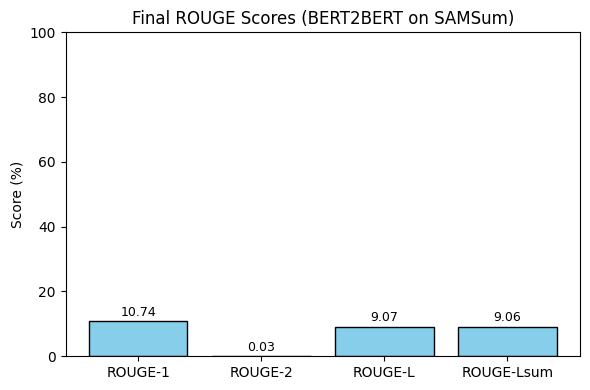

In [80]:
trainer = GenTrainer(
    model=model,
    args=args,
    train_dataset=small_train,           # or tokenized_dataset["train"]
    eval_dataset=small_val,              # or tokenized_dataset["validation"]
    data_collator=collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EvalEveryNSteps(500)],
)

trainer.train()
metrics = trainer.evaluate()

print("\n=== FLAN-T5 ROUGE (quick test) ===")
for k in ['eval_rouge1','eval_rouge2','eval_rougeL','eval_rougeLsum']:
    print(f"{k.replace('eval_','').upper():<10}: {metrics.get(k, float('nan')):.2f}")

# Your existing plotting helper — tweak title if you like
plot_final_rouge(metrics)


In [81]:
ex = small_train[0]
print("input_ids len:", len(ex["input_ids"]))
print("labels len   :", len(ex["labels"]))
print("INPUT  :", tokenizer.decode(ex["input_ids"][:160]))
print("LABELS :", tokenizer.decode([t for t in ex["labels"] if t != -100][:140]))

input_ids len: 67
labels len   : 29
INPUT  : summarize: Chris: can I borrow your car? Finn: what for? Chris: I have a date Finn: with who? Chris: Crystal Finn: wow, bro, she's hot <unk> Chris: so, what about the car? Finn: sure, but you need to fuel Chris: thanks, bro</s>
LABELS : Finn is going to lend his car to Chris, who needs it for a date with Crystal. Chris will refuel the car.</s>


In [82]:
# 1) Verify batched labels actually contain -100
batch = collator([small_train[0], small_train[1]])
print("Unique label values:", torch.unique(batch["labels"]))
print("Pad id:", tokenizer.pad_token_id)

# 2) Manual forward pass (proves loss flows)
batch = {k: v.to(model.device) for k, v in batch.items()}
model.train()
out = model(**batch)
print("Manual forward loss:", float(out.loss))

Unique label values: tensor([ -100,     1,     3,     5,     6,     7,     8,     9,    12,    19,
           21,    28,    34,    56,    60,    97,   112,   113,   149,   160,
          180,   352,   443,   523,   833,  1445,  3884,  4024,  4409,  8008,
        11845, 12961, 16173, 17502, 21692, 22896])
Pad id: 0
Manual forward loss: 10.377481460571289


In [83]:
# Build a fresh small batch
b = collator([small_train[0], small_train[1]])
b = {k: v.to(model.device) for k, v in b.items()}

import torch
from torch.optim import AdamW

model.train()
opt = AdamW(model.parameters(), lr=1e-3)  # big LR for a visible change

loss1 = model(**b).loss
loss1.backward()

total_grad = 0.0
for n,p in model.named_parameters():
    if p.grad is not None:
        total_grad += float(p.grad.data.abs().mean())

torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
opt.step()
opt.zero_grad()

loss2 = model(**b).loss
print("loss1 -> loss2:", float(loss1), "->", float(loss2), "| mean|grad|:", total_grad)

# Also check how many params require grad
trainable = sum(p.requires_grad for p in model.parameters())
total     = sum(1 for _ in model.parameters())
print(f"trainable params tensors: {trainable}/{total}")


loss1 -> loss2: 10.377481460571289 -> 10.377481460571289 | mean|grad|: 0.0
trainable params tensors: 282/282
